# Hacker: Al Smith

Testing script for a simplified version of GET3D using voxelgrid to create geometries of Dynamic Reference Frames provided by the I-Star Lab at JHU: https://github.com/I-STAR/DRF/tree/main/3D_Models/DRFs_with_posts/APPLE


In [67]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import trimesh
import io
import pyrender
import random
from skimage import measure
import open3d as o3d
import plotly.graph_objects as go

import matplotlib
#matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.ndimage import rotate

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

import ipywidgets as widgets
from IPython.display import display, clear_output

# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [68]:
# Just so you can see it here, this was my initial approach to 
# generating 2D images from 3D, however, it seems pretty clear 
# that nvdiffrast or something similar would be very important 
# to this pipeline, since this manual rendering process is
# extremely slow. However, there's a very convenient solution
# to random projection from 3D to 2D with voxel grids, which
# I show below.


def look_at(origin, target, up=np.array([0, 1, 0])):
    """
    Creates a camera pose matrix looking from origin to target with the specified up vector.
    """
    forward = target - origin
    forward /= np.linalg.norm(forward)
    
    right = np.cross(forward, up)
    right /= np.linalg.norm(right)
    
    true_up = np.cross(right, forward)
    
    # Create rotation matrix
    rotation = np.eye(4)
    rotation[:3, :3] = np.stack([right, true_up, -forward], axis=-1)
    
    # Create translation matrix
    translation = np.eye(4)
    translation[:3, 3] = origin
    
    # Camera pose matrix
    pose = translation @ rotation
    return pose

def render_single_image_pyrender(mesh_path, image_index, image_dir, image_size=64, fov_y=np.pi / 3.0):
    """
    Renders a single image of the mesh with random rotation and saves it.
    """
    try:
        # Load the mesh
        mesh = trimesh.load(mesh_path)
        
        if mesh.is_empty:
            print(f"Skipped {os.path.basename(mesh_path)} because it's empty.")
            return
        
        # Normalize and center the mesh
        mesh.apply_translation(-mesh.centroid)
        scale_factor = 1.0 / np.max(mesh.extents)
        mesh.apply_scale(scale_factor)
        
        # Apply random rotation
        random_rotation = trimesh.transformations.random_rotation_matrix()
        mesh.apply_transform(random_rotation)
        
        # Set up camera parameters
        camera_distance = 1.25  # Adjust as needed
        camera_position = np.array([0, 0, camera_distance])
        camera_target = np.array([0, 0, 0])
        camera_pose = look_at(camera_position, camera_target)
        
        # Create a pyrender scene
        scene = pyrender.Scene(bg_color=[255, 255, 255, 255], ambient_light=[0.5, 0.5, 0.5])
        mesh_pyrender = pyrender.Mesh.from_trimesh(mesh, smooth=False)
        scene.add(mesh_pyrender)
        
        # Add camera to the scene
        camera = pyrender.PerspectiveCamera(yfov=fov_y)
        scene.add(camera, pose=camera_pose)
        
        # Add lights
        light = pyrender.DirectionalLight(color=np.ones(3), intensity=2.0)
        scene.add(light, pose=camera_pose)
        
        # Initialize offscreen renderer
        renderer = pyrender.OffscreenRenderer(viewport_width=image_size, viewport_height=image_size)
        
        # Render the scene
        color, depth = renderer.render(scene)
        renderer.delete()
        
        # Convert to grayscale and save
        image = Image.fromarray(color)
        image = image.convert('L')  # Convert to grayscale
        
        # Create a unique filename
        mesh_name = os.path.splitext(os.path.basename(mesh_path))[0]
        image_filename = f"{mesh_name}_{image_index}.png"
        image.save(os.path.join(image_dir, image_filename))
        print(f"Rendered and saved {image_filename}")
    
    except Exception as e:
        print(f"Error rendering {os.path.basename(mesh_path)}: {e}")

def generate_images(mesh_dir, image_dir, num_images_per_mesh=10, image_size=64, fov_y=np.pi / 3.0):
    """
    Generates images for each mesh in the mesh directory.
    """
    os.makedirs(image_dir, exist_ok=True)
    mesh_files = [f for f in os.listdir(mesh_dir) if f.lower().endswith(('.stl', '.obj'))]
    
    for mesh_file in mesh_files:
        mesh_path = os.path.join(mesh_dir, mesh_file)
        print(f"Processing mesh: {mesh_file}")
        for i in range(num_images_per_mesh):
            render_single_image_pyrender(mesh_path, i, image_dir, image_size, fov_y)

# Define paths
mesh_dir = './stl_models/'         # Directory containing your CAD models
image_dir = './rendered_images/'   # Directory to save rendered images

# Generate images
generate_images(mesh_dir, image_dir, num_images_per_mesh=10, image_size=64)


Processing mesh: FIG_5_without_post.stl
Rendered and saved FIG_5_without_post_0.png
Rendered and saved FIG_5_without_post_1.png
Rendered and saved FIG_5_without_post_2.png
Rendered and saved FIG_5_without_post_3.png
Rendered and saved FIG_5_without_post_4.png
Rendered and saved FIG_5_without_post_5.png
Rendered and saved FIG_5_without_post_6.png
Rendered and saved FIG_5_without_post_7.png
Rendered and saved FIG_5_without_post_8.png
Rendered and saved FIG_5_without_post_9.png
Processing mesh: GUAVA_6_without_post.stl
Rendered and saved GUAVA_6_without_post_0.png
Rendered and saved GUAVA_6_without_post_1.png
Rendered and saved GUAVA_6_without_post_2.png
Rendered and saved GUAVA_6_without_post_3.png
Rendered and saved GUAVA_6_without_post_4.png
Rendered and saved GUAVA_6_without_post_5.png
Rendered and saved GUAVA_6_without_post_6.png


KeyboardInterrupt: 

In [69]:
def rotate_voxel(voxel_data, angles):
    # Rotate the voxel grid around each axis
    rotated = rotate(voxel_data, angle=np.degrees(angles[0]), axes=(1, 2), reshape=False, order=0)
    rotated = rotate(rotated, angle=np.degrees(angles[1]), axes=(0, 2), reshape=False, order=0)
    rotated = rotate(rotated, angle=np.degrees(angles[2]), axes=(0, 1), reshape=False, order=0)
    # Threshold to get binary voxel grid
    rotated = (rotated > 0.5).astype(np.float32)
    return rotated

def generate_projections_and_save(voxel_data, image_dir, mesh_name, num_views=10, image_size=64):
    os.makedirs(image_dir, exist_ok=True)
    voxel_dim = voxel_data.shape[0]
    for i in range(num_views):
        # Apply random rotation
        angles = np.random.uniform(0, 2 * np.pi, size=3)
        rotated_voxel = rotate_voxel(voxel_data, angles)
        
        # Project along a random axis
        axis = np.random.choice([0, 1, 2])
        projection = rotated_voxel.sum(axis=axis)
        
        # Normalize the projection
        if np.max(projection) > 0:
            projection = projection / np.max(projection)
        else:
            projection = projection
        
        # Resize the projection to desired image size
        image = Image.fromarray((projection * 255).astype(np.uint8))
        image = image.resize((image_size, image_size))
        
        # Save the image
        image_filename = f"{mesh_name}_{i}.png"
        image.save(os.path.join(image_dir, image_filename))
        print(f"Rendered and saved {image_filename}")


In [70]:
def mesh_to_voxel(mesh_path, voxel_dim=32):
    mesh = trimesh.load(mesh_path)
    # Normalize the mesh to fit in a unit cube centered at the origin
    mesh.apply_translation(-mesh.centroid)
    scale_factor = 1.0 / np.max(mesh.extents)
    mesh.apply_scale(scale_factor)
    # Create a grid of points within the unit cube
    linspaces = [np.linspace(-0.5, 0.5, voxel_dim) for _ in range(3)]
    grid = np.stack(np.meshgrid(*linspaces, indexing='ij'), -1).reshape(-1, 3)
    # Check which points are inside the mesh
    contains = mesh.contains(grid)
    voxel_data = contains.reshape((voxel_dim, voxel_dim, voxel_dim))
    return voxel_data.astype(np.float32)


# Voxelize and save all meshes
mesh_dir = './stl_models/'         # Directory containing your CAD models
image_dir = './rendered_images/'   # Directory to save rendered images
voxel_dir = './voxel_data/'
os.makedirs(voxel_dir, exist_ok=True)

for filename in os.listdir(mesh_dir):
    if filename.endswith('.stl') or filename.endswith('.obj'):
        mesh_path = os.path.join(mesh_dir, filename)
        voxel_data = mesh_to_voxel(mesh_path, voxel_dim=32)
        voxel_path = os.path.join(voxel_dir, filename + '.npy')
        np.save(voxel_path, voxel_data)
        print(f'Voxelized {filename}')


Voxelized FIG_5_without_post.stl
Voxelized GUAVA_6_without_post.stl
Voxelized JUJUBE_3_without_post.stl
Voxelized EGGFRUIT_4_without_post.stl
Voxelized HONEYDEW_6_without_post.stl
Voxelized GUAVA_4_without_post.stl
Voxelized DATE_5_without_post.stl
Voxelized DATE_3_without_post.stl
Voxelized BANANA_3_without_post.stl
Voxelized APPLE_5_without_post.stl
Voxelized KIWI_6_without_post.stl
Voxelized APPLE_1_without_post.stl
Voxelized BANANA_6_without_post.stl
Voxelized HONEYDEW_3_without_post.stl
Voxelized BANANA_4_without_post.stl
Voxelized EGGFRUIT_6_without_post.stl
Voxelized HONEYDEW_2_without_post.stl
Voxelized APPLE_3_without_post.stl
Voxelized GUAVA_5_without_post.stl
Voxelized BANANA_2_without_post.stl
Voxelized FIG_4_without_post.stl
Voxelized APPLE_8_without_post.stl
Voxelized GUAVA_1_without_post.stl
Voxelized EGGFRUIT_3_without_post.stl
Voxelized JUJUBE_6_without_post.stl
Voxelized CHERRY_3_without_post.stl
Voxelized JUJUBE_1_without_post.stl
Voxelized EGGFRUIT_5_without_post.st

Selected Mesh: JUJUBE_6_without_post.stl


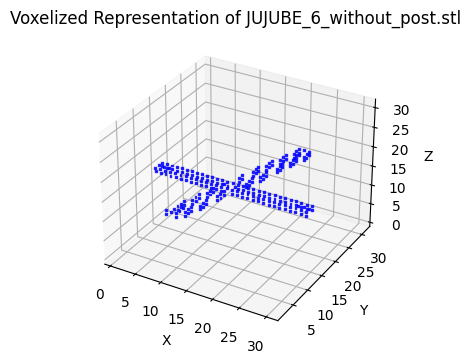

In [72]:
def display_random_voxel(mesh_dir, voxel_size=32):
    """
    Selects a random STL/OBJ file from the specified directory, voxelizes it,
    and displays the voxel representation using Matplotlib.
    """
    # List all STL and OBJ files in the directory
    mesh_files = [f for f in os.listdir(mesh_dir) if f.lower().endswith(('.stl', '.obj'))]
    
    if not mesh_files:
        print("No STL or OBJ files found in the specified directory.")
        return
    
    # Select a random mesh file
    selected_mesh = random.choice(mesh_files)
    mesh_path = os.path.join(mesh_dir, selected_mesh)
    print(f"Selected Mesh: {selected_mesh}")
    
    # Load and voxelize the mesh
    voxel_data = mesh_to_voxel(mesh_path, voxel_dim=voxel_size)
    
    # Get the coordinates of the occupied voxels
    filled = np.argwhere(voxel_data)
    x, y, z = filled[:,0], filled[:,1], filled[:,2]
    
    # Create a Matplotlib figure
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the voxels
    ax.scatter(x, y, z, c='blue', marker='s', s=2, alpha=0.8)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Voxelized Representation of {selected_mesh}')
    
    # Ensure equal aspect ratio
    set_axes_equal(ax)
    
    plt.show()
    
def set_axes_equal(ax):
    """
    Sets equal aspect ratio for 3D plots.
    
    Parameters:
    - ax (mpl_toolkits.mplot3d.Axes3D): The 3D axes to adjust.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a cube in the sense of the infinity norm
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def mesh_to_voxel(mesh_path, voxel_dim=32):
    """
    Converts a mesh to a voxel grid.
    
    Parameters:
    - mesh_path (str): Path to the mesh file.
    - voxel_dim (int): The dimension of the voxel grid.
    
    Returns:
    - voxel_data (np.ndarray): A 3D numpy array representing the voxel grid.
    """
    mesh = trimesh.load(mesh_path)
    if mesh.is_empty:
        print(f"Skipped {os.path.basename(mesh_path)} because it's empty.")
        return None
    
    # Normalize and center the mesh
    mesh.apply_translation(-mesh.centroid)
    scale_factor = 1.0 / np.max(mesh.extents)
    mesh.apply_scale(scale_factor)
    
    # Create a grid of points within the unit cube
    linspaces = [np.linspace(-0.5, 0.5, voxel_dim) for _ in range(3)]
    grid = np.stack(np.meshgrid(*linspaces, indexing='ij'), -1).reshape(-1, 3)
    
    # Check which points are inside the mesh
    contains = mesh.contains(grid)
    voxel_data = contains.reshape((voxel_dim, voxel_dim, voxel_dim))
    return voxel_data.astype(np.bool_)
    
# Define the directory containing your STL/OBJ files
mesh_directory = './stl_models/'

# Display a random voxelized mesh
display_random_voxel(mesh_directory, voxel_size=32)

In [73]:
# Define directories
mesh_dir = './stl_models/'
image_dir = './rendered_images/'
voxel_dir = './voxel_data/'
os.makedirs(voxel_dir, exist_ok=True)

# Generate images and voxel grids
for mesh_file in os.listdir(mesh_dir):
    if mesh_file.lower().endswith(('.stl', '.obj')):
        mesh_path = os.path.join(mesh_dir, mesh_file)
        # Voxelize the mesh
        voxel_data = mesh_to_voxel(mesh_path, voxel_dim=32)
        if voxel_data is None:
            continue
        # Save voxel grid
        voxel_filename = os.path.splitext(mesh_file)[0] + '.npy'
        np.save(os.path.join(voxel_dir, voxel_filename), voxel_data)
        print(f"Voxelized and saved {voxel_filename}")
        # Generate projections and save images
        mesh_name = os.path.splitext(mesh_file)[0]
        generate_projections_and_save(voxel_data, image_dir, mesh_name, num_views=10, image_size=64)


Voxelized and saved FIG_5_without_post.npy
Rendered and saved FIG_5_without_post_0.png
Rendered and saved FIG_5_without_post_1.png
Rendered and saved FIG_5_without_post_2.png
Rendered and saved FIG_5_without_post_3.png
Rendered and saved FIG_5_without_post_4.png
Rendered and saved FIG_5_without_post_5.png
Rendered and saved FIG_5_without_post_6.png
Rendered and saved FIG_5_without_post_7.png
Rendered and saved FIG_5_without_post_8.png
Rendered and saved FIG_5_without_post_9.png
Voxelized and saved GUAVA_6_without_post.npy
Rendered and saved GUAVA_6_without_post_0.png
Rendered and saved GUAVA_6_without_post_1.png
Rendered and saved GUAVA_6_without_post_2.png
Rendered and saved GUAVA_6_without_post_3.png
Rendered and saved GUAVA_6_without_post_4.png
Rendered and saved GUAVA_6_without_post_5.png
Rendered and saved GUAVA_6_without_post_6.png
Rendered and saved GUAVA_6_without_post_7.png
Rendered and saved GUAVA_6_without_post_8.png
Rendered and saved GUAVA_6_without_post_9.png
Voxelized an

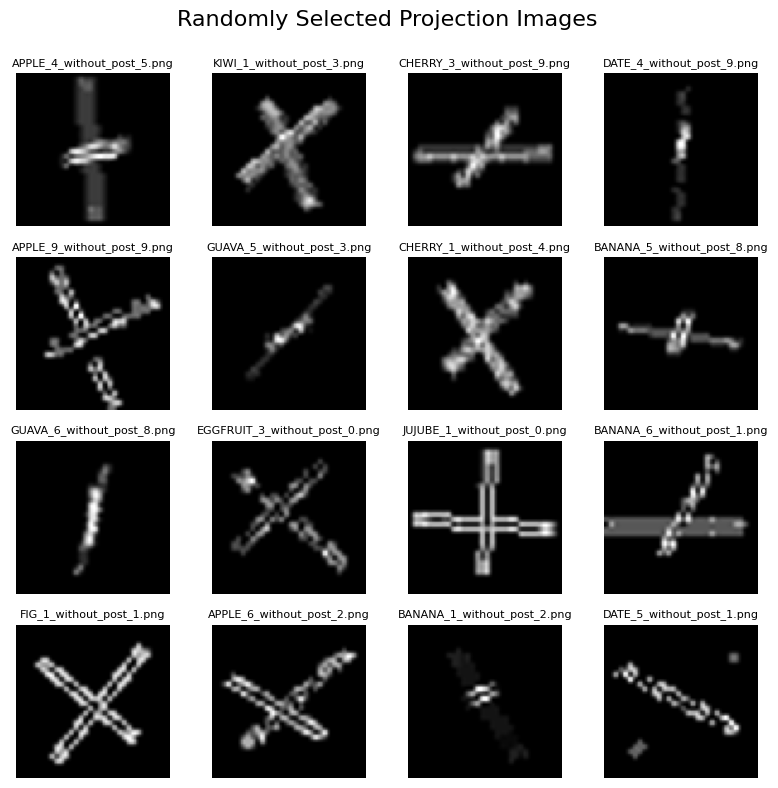

In [79]:
import matplotlib.image as mpimg

def plot_random_projection_images(image_dir, num_images=16, grid_size=(4, 4)):
    """
    Plots a grid of randomly selected projection images from a specified directory.

    Parameters:
    - image_dir (str): Path to the directory containing projection image files.
    - num_images (int): Total number of images to display (default is 16 for a 4x4 grid).
    - grid_size (tuple): Grid dimensions as (rows, columns) (default is (4, 4)).
    """
    # Supported image file extensions
    supported_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    # Retrieve all image files from the directory
    all_images = [file for file in os.listdir(image_dir) if file.lower().endswith(supported_extensions)]

    if not all_images:
        print(f"No image files found in the directory: {image_dir}")
        return

    num_images = min(num_images, len(all_images))
    selected_images = random.sample(all_images, num_images)

    # Create a figure with the specified grid size
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 8))
    fig.suptitle('Randomly Selected Projection Images', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    for idx in range(num_images):
        img_path = os.path.join(image_dir, selected_images[idx])
        img = mpimg.imread(img_path)

        # Display the image
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')  # Hide axis ticks

        # Add the image filename as the title (optional)
        axes[idx].set_title(selected_images[idx], fontsize=8)

    # Hide any remaining subplots if there are fewer images than grid spaces
    for idx in range(num_images, grid_size[0] * grid_size[1]):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust to make room for the main title
    plt.show()

# Example Usage

# Define the directory containing your projection images
rendered_images_directory = './rendered_images/'

# Plot a 4x4 grid of randomly selected projection images
plot_random_projection_images(rendered_images_directory, num_images=16, grid_size=(4, 4))

In [80]:
class PairedDataset(Dataset):
    def __init__(self, image_dir, voxel_dir):
        self.image_files = []
        self.voxel_files = []
        for image_file in os.listdir(image_dir):
            if image_file.endswith('.png'):
                mesh_name = '_'.join(image_file.split('_')[:-1])  # Extract mesh name
                voxel_file = mesh_name + '.npy'
                voxel_path = os.path.join(voxel_dir, voxel_file)
                if os.path.exists(voxel_path):
                    self.image_files.append(os.path.join(image_dir, image_file))
                    self.voxel_files.append(voxel_path)
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_files[idx]).convert('L')
        image = self.transform(image)
        # Load voxel grid
        voxel = np.load(self.voxel_files[idx])
        voxel = torch.tensor(voxel, dtype=torch.float32)
        return {'image': image, 'voxel': voxel}


dataset = PairedDataset(image_dir, voxel_dir)
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f'Total samples: {len(dataset)}')



Total samples: 620


# MODEL DEFINITIONS

In [107]:
class Generator(nn.Module):
    def __init__(self, voxel_dim=32):
        super(Generator, self).__init__()
        # Encoder: Convolutional layers to process 2D images
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # (batch_size, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # Add more layers as needed
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 512),
            nn.ReLU(True)
        )
        # Decoder: Transpose convolutional layers to generate 3D voxel grid
        self.decoder = nn.Sequential(
            nn.Linear(512, voxel_dim ** 3),
            nn.Sigmoid()
        )
        self.voxel_dim = voxel_dim

    def forward(self, img):
        encoded = self.encoder(img)
        decoded = self.decoder(encoded)
        voxel_grid = decoded.view(-1, self.voxel_dim, self.voxel_dim, self.voxel_dim)
        return voxel_grid


In [106]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 64, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 128, 64, 64)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (batch_size, 256, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),
            # Can add more layers here if needed
            nn.Flatten(),
            nn.Linear(256 * 32 * 2, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)


In [140]:
# Instantiate models
voxel_dim = 32
G = Generator(voxel_dim).to(device)
D = Discriminator().to(device)

d_losses = []
g_losses = []
recon_losses = []

In [141]:
# Loss functions
adversarial_loss_fn = nn.BCELoss()
reconstruction_loss_fn = nn.MSELoss()

# Optimizers
lr = 0.00005
beta1 = 0.5
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))


In [123]:
def render_voxel(voxel_tensor, num_views=5, image_size=64):
    """
    Render voxel grids from different viewpoints by applying random rotations
    and projecting along random axes.
    """
    batch_size = voxel_tensor.size(0)
    voxel_dim = voxel_tensor.size(1)
    images = []

    for i in range(batch_size):
        voxel = voxel_tensor[i]  # Shape: (D, H, W)
        for _ in range(num_views):
            # Apply random rotation
            angles = torch.rand(3) * 360  # Random angles in degrees
            angles = angles * (torch.pi / 180)  # Convert to radians

            # Create rotation matrices
            rot_x = torch.tensor([
                [1, 0, 0],
                [0, torch.cos(angles[0]), -torch.sin(angles[0])],
                [0, torch.sin(angles[0]), torch.cos(angles[0])]
            ], device=voxel.device)

            rot_y = torch.tensor([
                [torch.cos(angles[1]), 0, torch.sin(angles[1])],
                [0, 1, 0],
                [-torch.sin(angles[1]), 0, torch.cos(angles[1])]
            ], device=voxel.device)

            rot_z = torch.tensor([
                [torch.cos(angles[2]), -torch.sin(angles[2]), 0],
                [torch.sin(angles[2]), torch.cos(angles[2]), 0],
                [0, 0, 1]
            ], device=voxel.device)

            # Combined rotation matrix
            rotation_matrix = rot_z @ rot_y @ rot_x  # Shape: (3, 3)

            # Get indices of occupied voxels
            indices = torch.nonzero(voxel > 0.5).float()  # Shape: (N, 3)

            if indices.size(0) == 0:
                # If no occupied voxels, create a blank projection
                projection = torch.zeros((1, image_size, image_size), device=voxel.device)
            else:
                # Center the indices
                indices -= voxel_dim / 2

                # Apply rotation
                rotated_indices = indices @ rotation_matrix.T

                # Shift back to original coordinate space
                rotated_indices += voxel_dim / 2

                # Round and clip indices to valid range
                rotated_indices = rotated_indices.round().long()
                rotated_indices = torch.clamp(rotated_indices, 0, voxel_dim - 1)

                # Create new voxel grid
                rotated_voxel = torch.zeros_like(voxel)
                rotated_voxel[rotated_indices[:, 0], rotated_indices[:, 1], rotated_indices[:, 2]] = 1.0

                # Sum along a random axis to create projection
                axis = torch.randint(0, 3, (1,)).item()
                projection = rotated_voxel.sum(dim=axis)  # Shape: (D, D)

                # Normalize the projection
                if projection.max() > 0:
                    projection = projection / projection.max()
                else:
                    projection = projection

                projection = projection.unsqueeze(0)  # Add channel dimension

                # Resize to desired image size using nearest neighbor interpolation
                projection = F.interpolate(projection.unsqueeze(0), size=(image_size, image_size), mode='nearest')
                projection = projection.squeeze(0)

            images.append(projection)

    if len(images) == 0:
        # If no images were generated, return a tensor of zeros
        images = torch.zeros((batch_size * num_views, 1, image_size, image_size), device=voxel_tensor.device)
    else:
        images = torch.stack(images, dim=0)  # Shape: (num_views * batch_size, 1, H, W)
    return images.to(voxel_tensor.device)


In [142]:
num_epochs = 50
lambda_recon = 50  # Weight for reconstruction loss
num_views = 10      # Number of views to render per voxel grid

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        # ---------------------
        #  Prepare Data
        # ---------------------
        real_images = data['image'].to(device)        # (batch_size, 1, 64, 64)
        real_voxels = data['voxel'].to(device)        # (batch_size, D, D, D)
        batch_size = real_images.size(0)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate voxel grid from image
        gen_voxels = G(real_images)                   # (batch_size, D, D, D)

        # Reconstruction loss
        g_recon_loss = reconstruction_loss_fn(gen_voxels, real_voxels)

        # Render images from generated voxel grid
        rendered_images = render_voxel(gen_voxels, num_views=num_views, image_size=64)
        valid_labels = torch.ones(rendered_images.size(0), 1, device=device)

        # Adversarial loss
        g_adv_loss = adversarial_loss_fn(D(rendered_images), valid_labels)

        # Total generator loss
        g_loss = g_adv_loss + lambda_recon * g_recon_loss

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Prepare real images expanded to match rendered_images batch size
        real_images_expanded = real_images.unsqueeze(1).repeat(1, num_views, 1, 1, 1)
        real_images_expanded = real_images_expanded.view(-1, 1, 64, 64)  # (batch_size * num_views, 1, 64, 64)
        valid_labels_real = torch.ones(real_images_expanded.size(0), 1, device=device)
        fake_labels = torch.zeros(rendered_images.size(0), 1, device=device)

        # Discriminator loss on real images
        d_real_loss = adversarial_loss_fn(D(real_images_expanded), valid_labels_real)

        # Discriminator loss on fake images
        d_fake_loss = adversarial_loss_fn(D(rendered_images.detach()), fake_labels)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Logging
        # ---------------------
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        recon_losses.append(g_recon_loss.item())

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                  f'Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}, '
                  f'Recon Loss: {g_recon_loss.item():.4f}')


Epoch [1/50] Batch [0/78] Loss D: 0.6915, Loss G: 13.3054, Recon Loss: 0.2521
Epoch [1/50] Batch [10/78] Loss D: 0.5960, Loss G: 11.8429, Recon Loss: 0.2183
Epoch [1/50] Batch [20/78] Loss D: 0.4327, Loss G: 8.3212, Recon Loss: 0.1412
Epoch [1/50] Batch [30/78] Loss D: 0.4094, Loss G: 4.5445, Recon Loss: 0.0688
Epoch [1/50] Batch [40/78] Loss D: 0.5260, Loss G: 2.6849, Recon Loss: 0.0303
Epoch [1/50] Batch [50/78] Loss D: 0.6355, Loss G: 1.6969, Recon Loss: 0.0171
Epoch [1/50] Batch [60/78] Loss D: 0.6297, Loss G: 1.4514, Recon Loss: 0.0138
Epoch [1/50] Batch [70/78] Loss D: 0.6468, Loss G: 1.3161, Recon Loss: 0.0117
Epoch [2/50] Batch [0/78] Loss D: 0.6195, Loss G: 1.2615, Recon Loss: 0.0107
Epoch [2/50] Batch [10/78] Loss D: 0.5487, Loss G: 1.3294, Recon Loss: 0.0100
Epoch [2/50] Batch [20/78] Loss D: 0.5113, Loss G: 1.3881, Recon Loss: 0.0107
Epoch [2/50] Batch [30/78] Loss D: 0.4449, Loss G: 1.5446, Recon Loss: 0.0104
Epoch [2/50] Batch [40/78] Loss D: 0.5310, Loss G: 1.4267, Recon

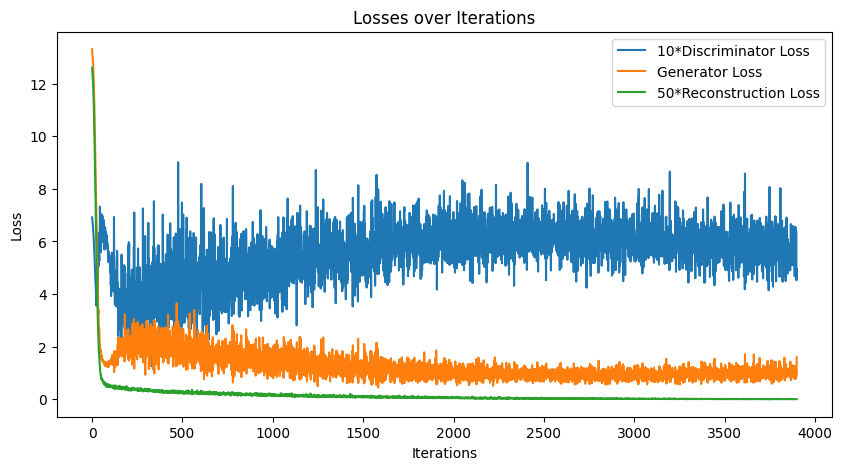

In [143]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot([10 * loss for loss in d_losses], label='10*Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.plot([50 * loss for loss in recon_losses], label='50*Reconstruction Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses over Iterations')
plt.show()

In [126]:
def plot_voxel(voxel):
    """
    Plots a scatter cloud of the centers of the filled voxels.

    Parameters:
    - voxel (torch.Tensor): The voxel grid tensor of shape (D, H, W).
    """
    voxel = voxel.detach().cpu().numpy()
    voxel = voxel > 0.5  # Threshold to binary

    # Get the indices of the occupied voxels
    filled = np.argwhere(voxel)
    if filled.size == 0:
        print("No occupied voxels to display.")
        return

    x, y, z = filled[:, 0], filled[:, 1], filled[:, 2]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the voxel centers
    ax.scatter(x, y, z, c='blue', marker='o', s=10, alpha=0.8)

    set_axes_equal(ax)  # Ensure equal aspect ratio
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close the figure to free up memory

def visualize_generated_images(gen_voxels, real_voxels, num_samples=8, image_size=64):
    """
    Plots a grid comparing generated and ground truth 2D projections.

    Parameters:
    - gen_voxels (torch.Tensor): Generated voxel grids, shape (batch_size, D, H, W)
    - real_voxels (torch.Tensor): Ground truth voxel grids, shape (batch_size, D, H, W)
    - num_samples (int): Number of samples to display (default is 8)
    - image_size (int): Size of the projection images (default is 64)
    """
    device = gen_voxels.device
    batch_size = gen_voxels.size(0)
    num_samples = min(num_samples, batch_size)

    # Randomly select samples
    indices = torch.randperm(batch_size)[:num_samples]

    images = []
    for idx in indices:
        gen_voxel = gen_voxels[idx:idx+1]  # Shape: (1, D, H, W)
        real_voxel = real_voxels[idx:idx+1]  # Shape: (1, D, H, W)

        # Generate projections for both generated and real voxels
        gen_projection = render_voxel(gen_voxel, num_views=1, image_size=image_size)
        real_projection = render_voxel(real_voxel, num_views=1, image_size=image_size)

        # Add projections to the images list
        images.append(gen_projection[0])  # Generated projection
        images.append(real_projection[0])  # Ground truth projection

    # Create grid image
    grid_img = torchvision.utils.make_grid(images, nrow=4, padding=2, normalize=True)

    # Plot the grid image
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title('Generated (Left) vs Ground Truth (Right) Projections')
    plt.show()


def set_axes_equal(ax):
    """
    Sets equal aspect ratio for 3D plots.

    Parameters:
    - ax (mpl_toolkits.mplot3d.Axes3D): The 3D axes to adjust.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity norm, hence max range
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def render_voxel(voxel_grid, num_views=1, image_size=64):
    """
    Render voxel grids from different viewpoints by applying random rotations
    and projecting along random axes using PyTorch operations.
    """
    # Move voxel_grid to CPU
    device = voxel_grid.device
    voxel_grid_cpu = voxel_grid.cpu()
    batch_size = voxel_grid_cpu.size(0)
    voxel_dim = voxel_grid_cpu.size(1)
    images = []

    for i in range(batch_size):
        voxel = voxel_grid_cpu[i:i+1]  # Shape: (1, D, H, W)
        voxel = voxel.unsqueeze(0)  # Shape: (1, 1, D, H, W)
        for _ in range(num_views):
            # Generate random rotation angles
            angles = torch.rand(3) * 2 * torch.pi  # Random angles in radians

            # Create rotation matrices for each axis
            Rx = torch.tensor([
                [1, 0, 0],
                [0, torch.cos(angles[0]), -torch.sin(angles[0])],
                [0, torch.sin(angles[0]), torch.cos(angles[0])]
            ])

            Ry = torch.tensor([
                [torch.cos(angles[1]), 0, torch.sin(angles[1])],
                [0, 1, 0],
                [-torch.sin(angles[1]), 0, torch.cos(angles[1])]
            ])

            Rz = torch.tensor([
                [torch.cos(angles[2]), -torch.sin(angles[2]), 0],
                [torch.sin(angles[2]), torch.cos(angles[2]), 0],
                [0, 0, 1]
            ])

            # Combined rotation matrix
            R = Rz @ Ry @ Rx  # Shape: (3, 3)

            # Create affine transformation matrix
            R_affine = torch.cat([R, torch.zeros(3,1)], dim=1)  # Shape: (3, 4)
            R_affine = R_affine.unsqueeze(0)  # Shape: (1, 3, 4)

            # Create sampling grid
            grid = F.affine_grid(R_affine, size=voxel.size(), align_corners=False)

            # Apply grid sample
            rotated_voxel = F.grid_sample(voxel, grid, mode='bilinear', align_corners=False, padding_mode='zeros')

            # Remove batch and channel dimensions
            rotated_voxel = rotated_voxel[0, 0]  # Shape: (D, H, W)

            # Threshold to get binary voxel grid
            rotated_voxel = (rotated_voxel > 0.5).float()

            # Sum along a random axis to create projection
            axis = torch.randint(0, 3, (1,)).item()
            projection = rotated_voxel.sum(dim=axis)  # Shape: (D, D)

            # Normalize the projection
            if projection.max() > 0:
                projection = projection / projection.max()
            projection = projection.unsqueeze(0)  # Add channel dimension

            # Resize to desired image size
            projection = F.interpolate(projection.unsqueeze(0), size=(image_size, image_size), mode='bilinear', align_corners=False)
            projection = projection.squeeze(0)

            images.append(projection)

    images = torch.stack(images, dim=0)  # Shape: (num_views * batch_size, 1, H, W)
    return images.to(device)

Sample 1:
Generated Voxel Grid:


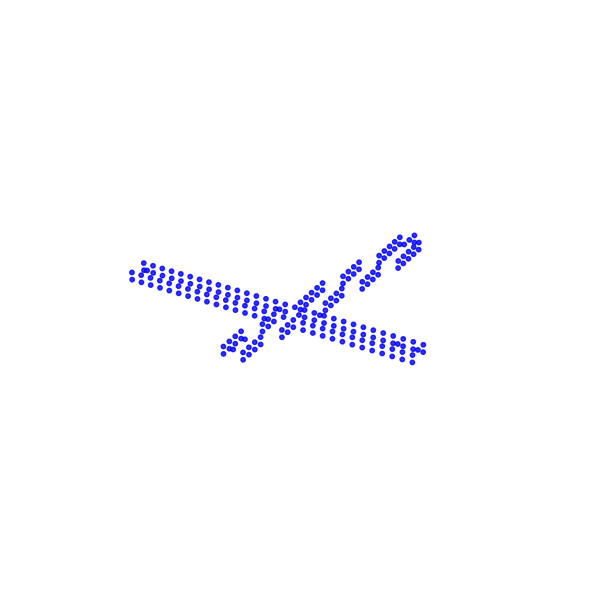

Ground Truth Voxel Grid:


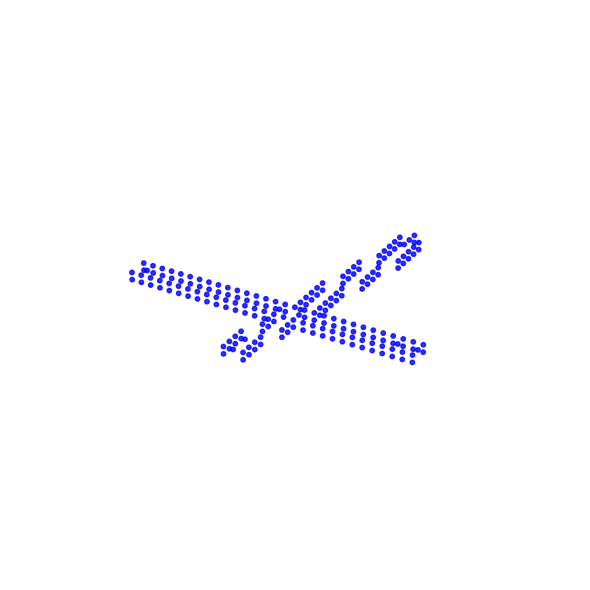

Rendered Images from Generated Voxel Grid:


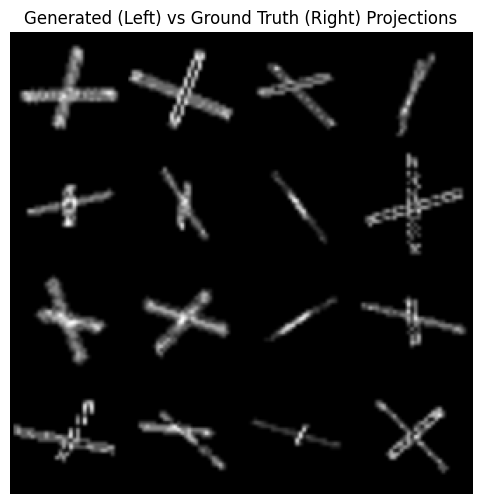

Sample 2:
Generated Voxel Grid:


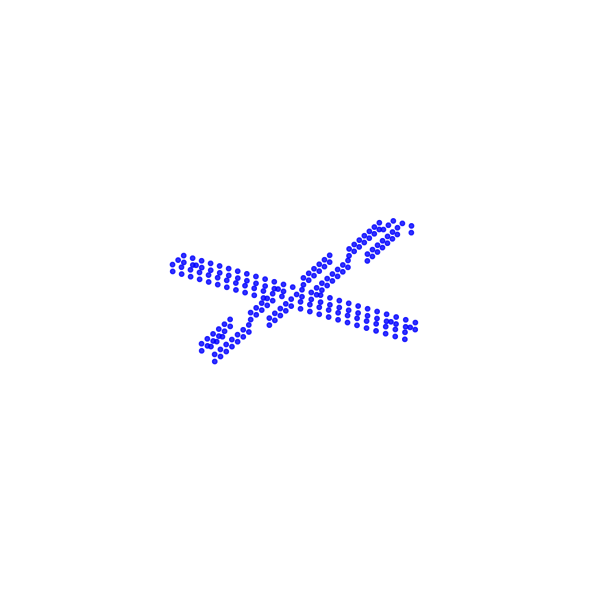

Ground Truth Voxel Grid:


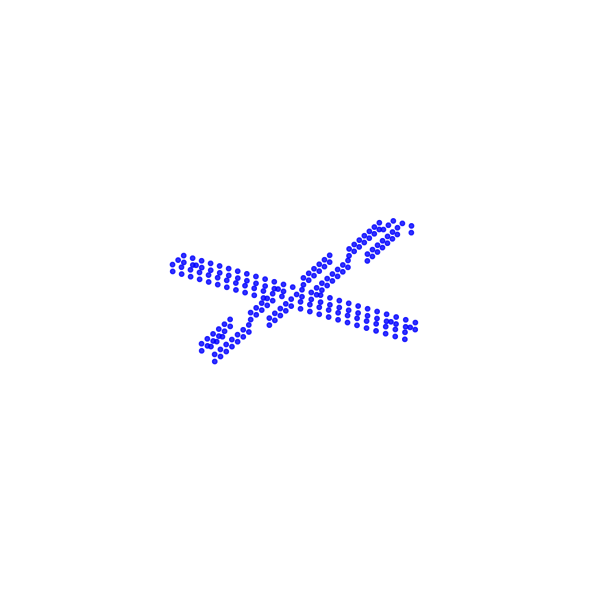

Rendered Images from Generated Voxel Grid:


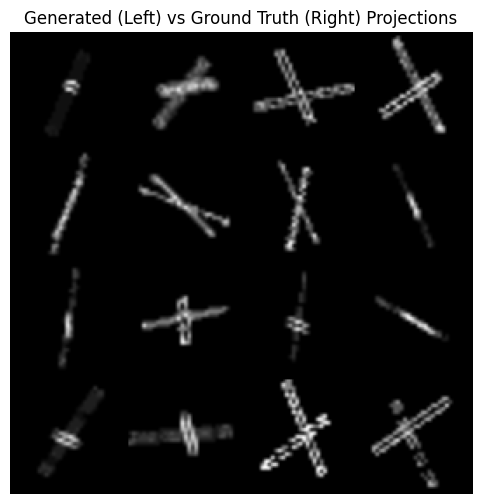

Sample 3:
Generated Voxel Grid:


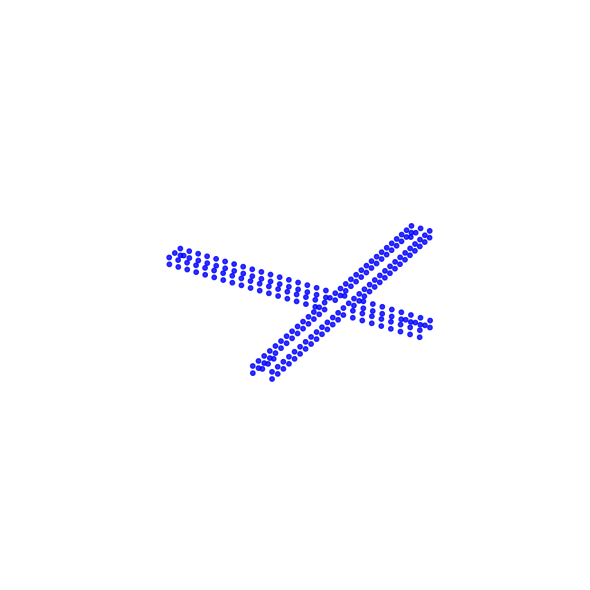

Ground Truth Voxel Grid:


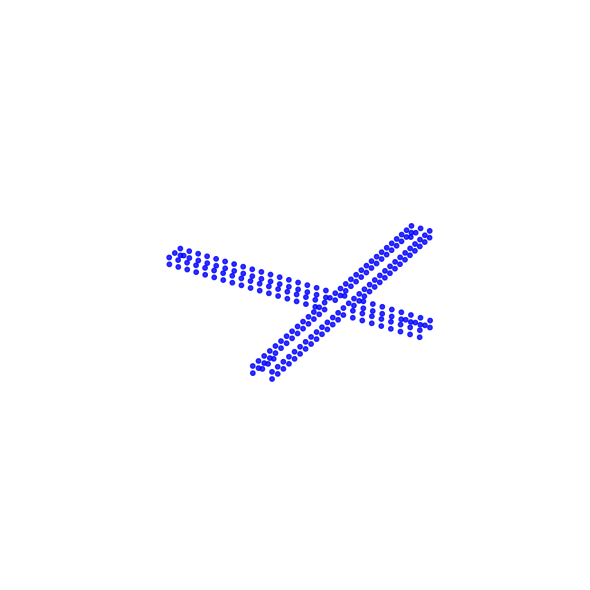

Rendered Images from Generated Voxel Grid:


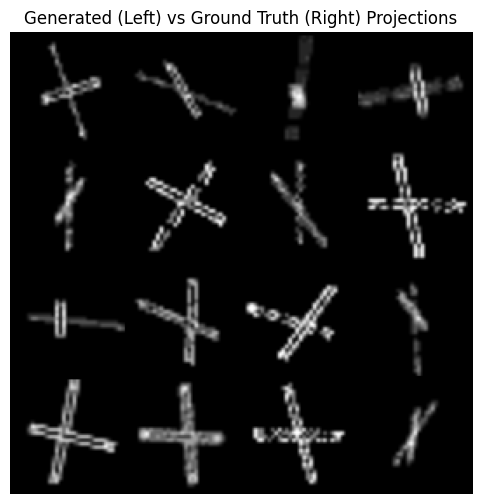

Sample 4:
Generated Voxel Grid:


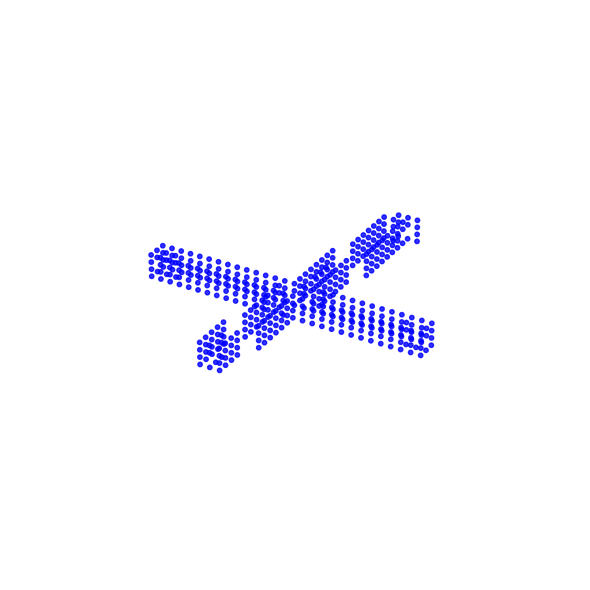

Ground Truth Voxel Grid:


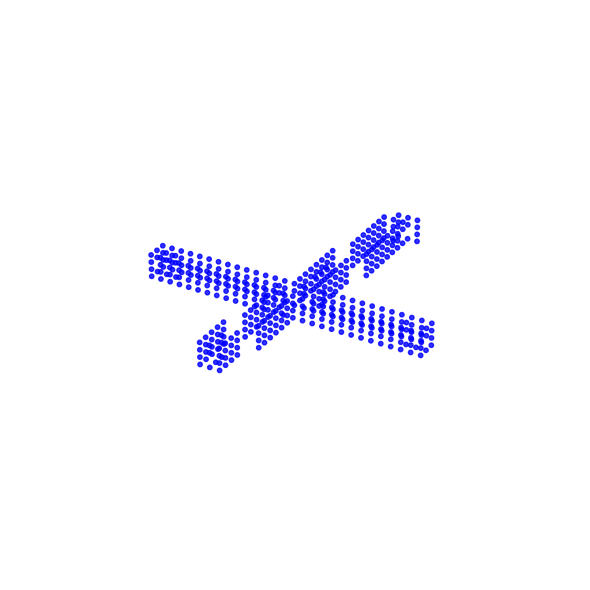

Rendered Images from Generated Voxel Grid:


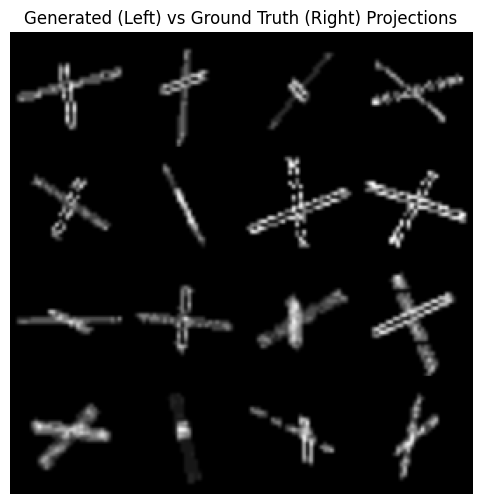

Sample 5:
Generated Voxel Grid:


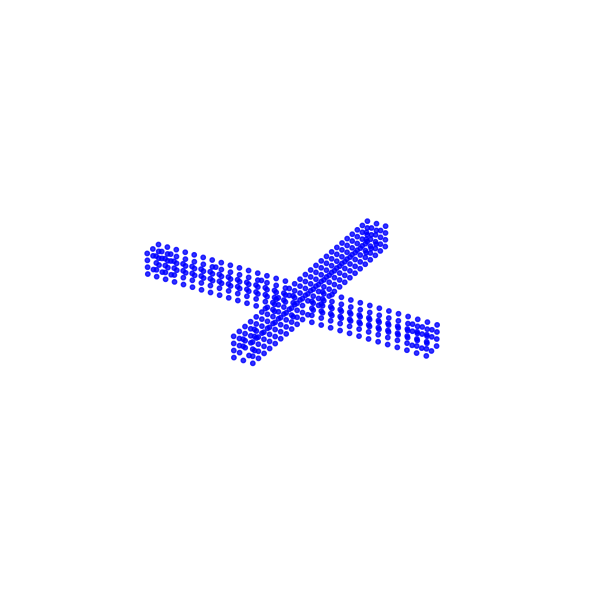

Ground Truth Voxel Grid:


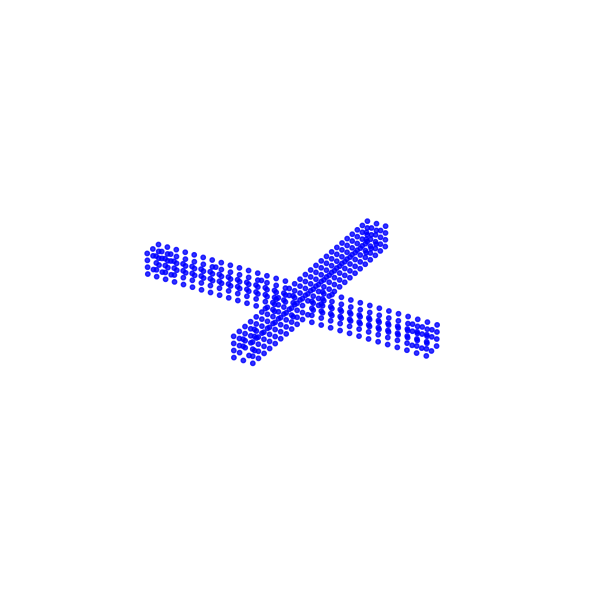

Rendered Images from Generated Voxel Grid:


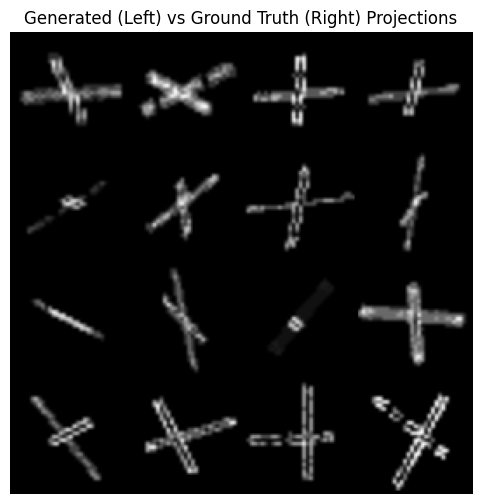

In [144]:
# Get a batch of data
data_iter = iter(dataloader)
data_sample = next(data_iter)
real_images = data_sample['image'].to(device)
real_voxels = data_sample['voxel'].to(device)

# Generate voxel grids
gen_voxels = G(real_images)

# Visualize generated voxel grids
for i in range(5):  # Display 3 samples
    print(f"Sample {i+1}:")
    print("Generated Voxel Grid:")
    plot_voxel(gen_voxels[i])
    print("Ground Truth Voxel Grid:")
    plot_voxel(real_voxels[i])
    print("Rendered Images from Generated Voxel Grid:")
    visualize_generated_images(gen_voxels, real_voxels, num_samples=8, image_size=64)

